In [1]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load label names    
label_names = loadmat('label_names.mat', squeeze_me=True)
activity_names_indexed = label_names['activity_names_indexed']

In [3]:
# Function to extract raw data from files stored in allData folder
def compute_raw_data(dir_name):

    # Load label names    
    label_names = loadmat('label_names.mat', squeeze_me=True)
    activity_names_indexed = label_names['activity_names_indexed']

    # Function to enumerate and assign number labels against different activity names
    string_to_number = {string: number for number, string in enumerate(activity_names_indexed, start=1)}

    # Initialize data arrays
    y_accel_all = []
    y_bar_all = []
    y_bar_ts_all = []
    y_label_all = []
    y_user_all = []
    y_activity_all = []
    column_names_accel = ['ts', 'accel_x', 'accel_y','accel_z']
    y_accel_all_df = pd.DataFrame(columns= column_names_accel)

    # Iterate through accel files
    files = [f for f in os.listdir(dir_name) if f.endswith('-accel.txt')]
    for file_name in files:
        # Extracting activity name, netID from file names
        # for files where there is no IMEI number
        if(file_name[0:4]=='null'):
            substr = dir_name[dir_name.find("allData/")+8:]
            file_name_prefix = file_name[:-(11+len(substr))]
            file_name_common = file_name[:-(10)]
            activity_name = file_name[25:-(11+len(substr))]
        # for files where there is a 15 digit IMEI number  
        else:
            substr = dir_name[dir_name.find("allData/")+8:]
            file_name_prefix = file_name[:-(11+len(substr))]
            file_name_common = file_name[:-(10)]
            activity_name = file_name[36:-(11+len(substr))]

        for activity_index in range(1, len(activity_names_indexed) + 1):
            if len([1 for name in activity_names_indexed if activity_name in name]) > 0:
                break

        # loading acceleration data    
        accel_data = np.loadtxt(os.path.join(dir_name, file_name), delimiter=',')
        ts, accel_x, accel_y, accel_z = accel_data[:, 0], accel_data[:, 1], accel_data[:, 2], accel_data[:, 3]


        # Removing duplicate timestamps
        ts_same = np.where(ts[:-1] == ts[1:])[0]
        accel_data = np.delete(accel_data, ts_same, axis=0)

        # storing data in dataframe
        column_names_accel = ['ts', 'accel_x', 'accel_y','accel_z']
        df_accel_data = pd.DataFrame(accel_data,columns= column_names_accel)

        # sorting data based on timestamp and interpolating data 
        df_accel_data = df_accel_data.sort_values('ts')
        df_accel_data = df_accel_data.interpolate(method='spline', order=2)

        # time to exclude (first and last few seconds are excluded from analysis)
        time_to_exclude = 2
        df_accel_data_trim = df_accel_data.iloc[time_to_exclude*32:-1*time_to_exclude*32]

        # for the same activity and netID, extracting the pressure values as well

        file_name_baro = file_name_common+"-pressure.txt"
        bar_data = np.loadtxt(os.path.join(dir_name, file_name_baro), delimiter=',')
        ts_bar, y_bar = bar_data[:, 0], bar_data[:, 1]

        # Remove duplicate timestamps
        ts_same_bar = np.where(ts_bar[:-1] == ts_bar[1:])[0]
        bar_data = np.delete(bar_data, ts_same_bar, axis=0)

        # checking acceleration and pressure data length
        desired_length = len(df_accel_data)
        bar_data_len = len(bar_data)

        # Interpolate barometer data to match the length of accel_data
        interp_indices = np.linspace(0, bar_data_len - 1, desired_length)
        y_bar_interp = interp1d(np.arange(bar_data_len), bar_data[:, 1], kind='linear', fill_value='extrapolate')
        y_bar_interpolated = y_bar_interp(interp_indices)

        # Smooth interpolated barometer data
        window_size = 4 * 128
        y_bar_smoothed = savgol_filter(y_bar_interpolated, window_size, 1,mode='nearest')

        # Trim data based on time_to_exclude
        start_idx = int(time_to_exclude * 32)
        end_idx = -start_idx if start_idx > 0 else None
        y_bar_trimmed = y_bar_smoothed[start_idx:end_idx]
        
        # if activity is present in list of activities
        if activity_name in activity_names_indexed:

            y_label = np.full(len(y_bar_trimmed), string_to_number[activity_name])
            y_activity = np.full(len(y_bar_trimmed), activity_name)
            y_user = np.full(len(y_bar_trimmed), substr)

            # only sets of 128 data is processed
            multiple_of_128 = 128 * (len(y_label) // 128)
            y_bar_f = y_bar_trimmed[:multiple_of_128]
            y_label_f = y_label[:multiple_of_128]
            y_user_f = y_user[:multiple_of_128]
            y_activity_f = y_activity[:multiple_of_128]

            y_accel_f = df_accel_data_trim.iloc[:multiple_of_128, :]

            # Concatenate results into new arrays
            y_accel_all_df = pd.concat([y_accel_all_df, y_accel_f],ignore_index=True)
            y_label_all = np.concatenate((y_label_all, y_label_f))
            y_user_all = np.concatenate((y_user_all, y_user_f))
            y_activity_all = np.concatenate((y_activity_all, y_activity_f))
            y_bar_all = np.concatenate((y_bar_all, y_bar_f))

    # add pressure,label,user and activity values into dataframe  
    y_accel_all_df['y_bar'] = y_bar_all
    y_accel_all_df['label'] = y_label_all
    y_accel_all_df['user'] = y_user_all
    y_accel_all_df['activity'] = y_activity_all

    # returning final dataframe
    return y_accel_all_df

TO DO 

Set your NetID below.

## Because of the flu, I couldn't participate in the experiments for data collection. I feel disappointed and regretful about missing out. Therefore, I randomly choose a student's NetID for analysis. I'm so sorry for this issue.

In [4]:
# Randomly chose
import random
random.seed(71)
files = []
for file in os.listdir(os.path.join(os.getcwd(), 'allData')):
    if not '.' in file:
        files.append(file)

print(random.choice(files))

loy004


In [5]:
# Set your netid
my_netid = 'loy004'

In [6]:
# Location of data directory
data_dir = os.path.join(os.getcwd(), 'allData')

In [7]:
col_names_raw = ['ts', 'accel_x', 'accel_y','accel_z','y_bar','label','user','activity']
df_raw = pd.DataFrame(columns= col_names_raw)

In [8]:
# Extracting all raw data by iterating through the files

for data_dir_name in os.listdir(data_dir):
    # Goes through all of the directories representing all imei addresses
    if os.path.isdir(os.path.join(data_dir, data_dir_name)) and data_dir_name[0] != '.':

        print(f'Processing directory {data_dir_name}')
        # Compute raw data
        dir_path = os.path.join(data_dir, data_dir_name)
        df_raw_temp = compute_raw_data(dir_path)

        df_raw_temp = df_raw_temp.sort_values(by = ['label', 'ts'], ignore_index=True)
        df_raw = pd.concat([df_raw, df_raw_temp],ignore_index=True)


Processing directory ahs264
Processing directory cyt25
Processing directory xl549
Processing directory jl2855
Processing directory xz278
Processing directory johnsweeney
Processing directory shl118
Processing directory mmill
Processing directory mrossman
Processing directory sutreja
Processing directory loy004
Processing directory jao57
Processing directory aaleksanyan
Processing directory aks249
Processing directory mmb289
Processing directory av452
Processing directory sp2333
Processing directory nbw32
Processing directory MASFIQ
Processing directory nk428
Processing directory mlc299
Processing directory cgp46
Processing directory wh298
Processing directory jps394
Processing directory abhandarkar
Processing directory bl4521
Processing directory ktc36


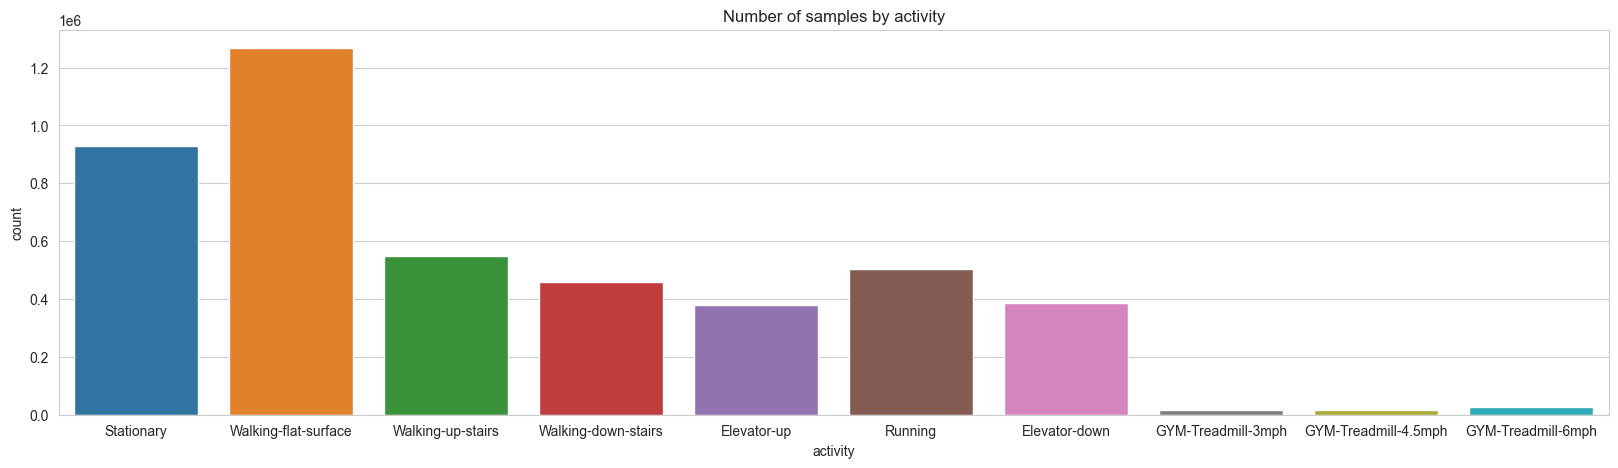

In [9]:
# Distribution of activities 
sns.set_style("whitegrid")
plt.figure(figsize = (20, 5))
sns.countplot(x = "activity", data = df_raw)
plt.title("Number of samples by activity")
plt.show()

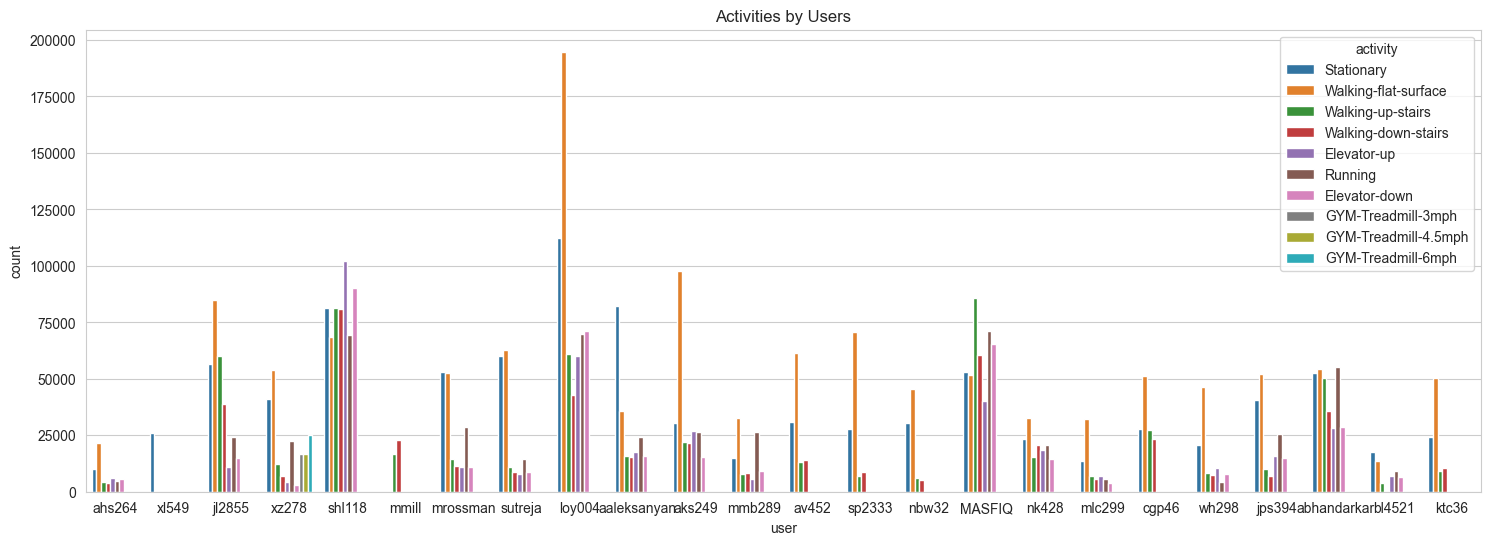

In [10]:
# Distribution of activities among different users

plt.figure(figsize = (18, 6))
sns.countplot(x = "user", hue = "activity", data = df_raw)
plt.title("Activities by Users")
plt.show()

In [11]:
df_raw

,ts,accel_x,accel_y,accel_z,y_bar,label,user,activity
0,1.424731e+12,-0.002694,-0.285007,9.264983,998.346950,1.0,ahs264,Stationary
1,1.424731e+12,-0.053289,-0.001946,9.371412,998.346655,1.0,ahs264,Stationary
2,1.424731e+12,0.084125,-0.322130,9.236543,998.346356,1.0,ahs264,Stationary
3,1.424731e+12,0.316143,-0.003593,9.294771,998.346056,1.0,ahs264,Stationary
4,1.424731e+12,0.015119,-0.283510,9.123378,998.345753,1.0,ahs264,Stationary
...,...,...,...,...,...,...,...,...
4534523,1.457007e+12,-0.229157,3.002625,9.205399,996.077881,4.0,ktc36,Walking-down-stairs
4534524,1.457007e+12,-0.202972,3.009766,9.179215,996.077861,4.0,ktc36,Walking-down-stairs
4534525,1.457007e+12,-0.122040,2.993103,8.993546,996.077842,4.0,ktc36,Walking-down-stairs
4534526,1.457007e+12,-0.148224,2.957397,8.874527,996.077822,4.0,ktc36,Walking-down-stairs


In [12]:
# splitting train data and test data 
df_train = df_raw[df_raw['user'] != my_netid]
df_test = df_raw[df_raw['user'] == my_netid]

In [13]:
print(df_train.shape)
print(df_test.shape)

(3922688, 8)
(611840, 8)


In [14]:
df_raw["user"].unique()

array(['ahs264', 'xl549', 'jl2855', 'xz278', 'shl118', 'mmill',
       'mrossman', 'sutreja', 'loy004', 'aaleksanyan', 'aks249', 'mmb289',
       'av452', 'sp2333', 'nbw32', 'MASFIQ', 'nk428', 'mlc299', 'cgp46',
       'wh298', 'jps394', 'abhandarkar', 'bl4521', 'ktc36'], dtype=object)

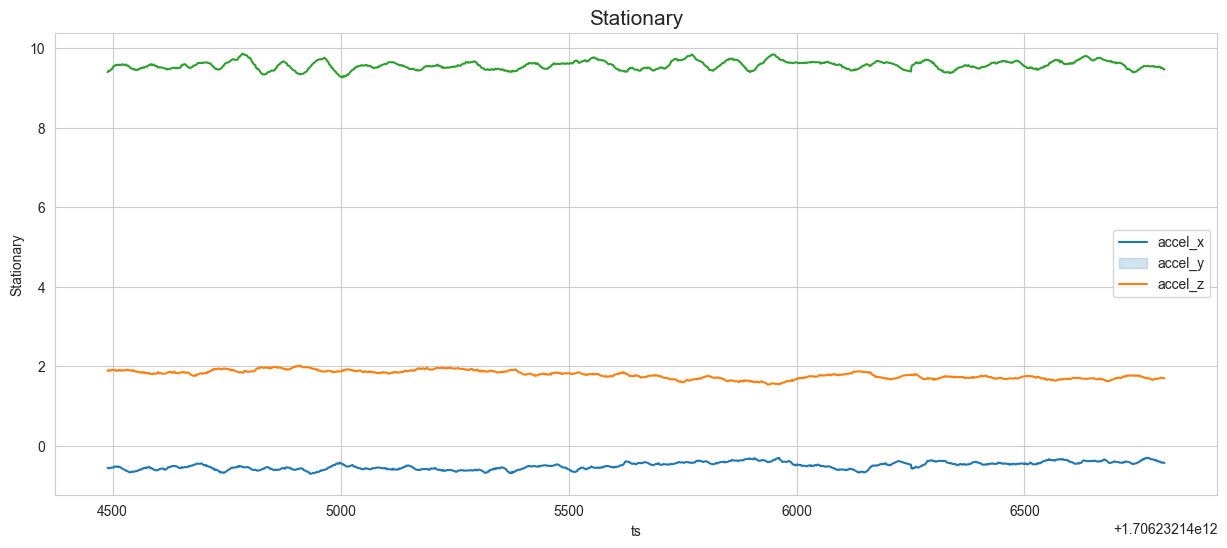

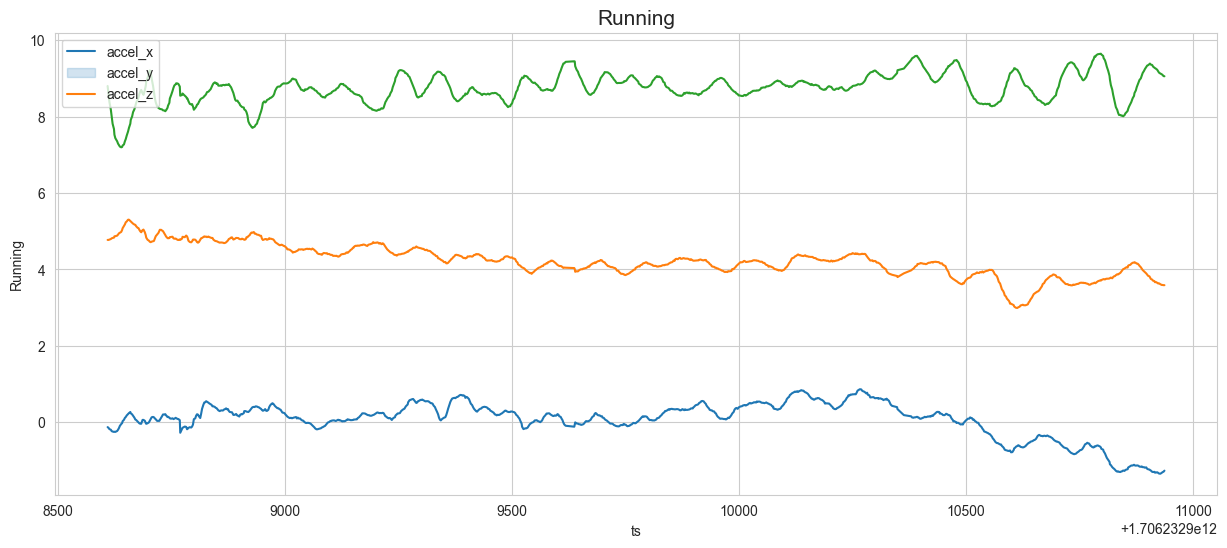

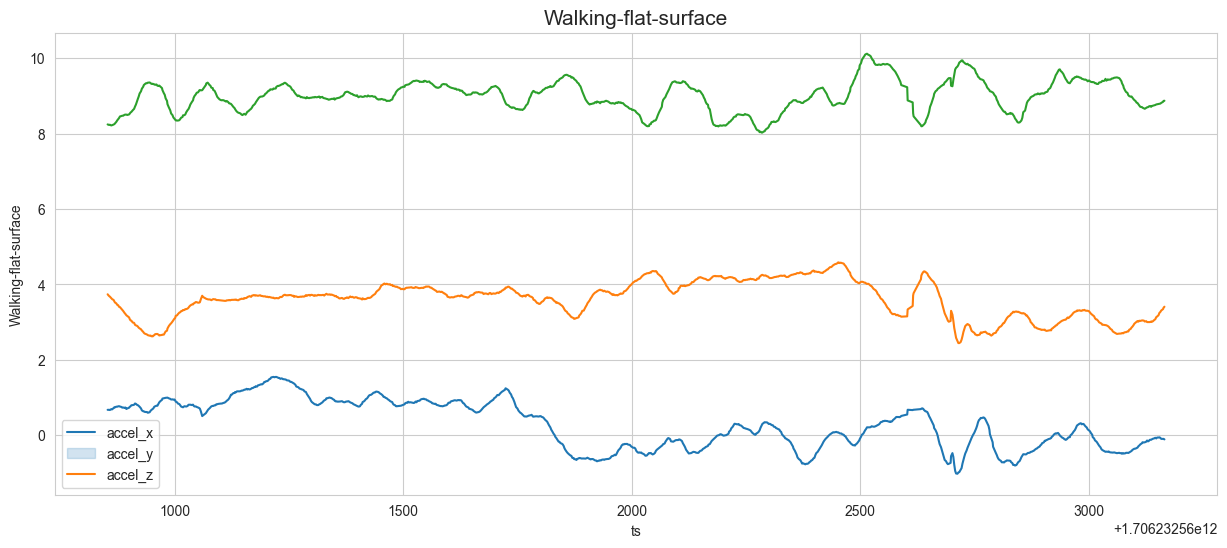

In [15]:
# Visual representation of raw data
# Note how the magnitudes and signal varies for each activity

for i in ["Stationary", "Running", "Walking-flat-surface"]:
    data_x = df_raw[(df_raw["user"] == my_netid) & (df_raw["activity"] == i)][:1000]
    plt.figure(figsize = (15, 6))
    sns.lineplot(y = "accel_x", x = "ts", data = data_x)
    sns.lineplot(y = "accel_y", x = "ts", data = data_x)
    sns.lineplot(y = "accel_z", x = "ts", data = data_x)
    plt.legend(["accel_x", "accel_y", "accel_z"])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()


### Do you see any interesting trends while observing signals from different activities (like walking, running stationary) ? Explain what you see. Can you think of any specific feature that might help us to differentiate among different activities? You will write a paragraph on this.

**Answer:** 

Upon analyzing the graph, I identified distinct trends that could serve to distinguish between various activities. For stationary activities, the accelerometer signals or accel_x, accel_y, accel_z show relatively constant values with small fluctuations. Conversely, during running, the signals display a clear periodic pattern, particularly in the z-axis, indicating vertical movement. The amplitude of the z-axis is notably greater during running compared to walking, as expected given the higher intensity of this activity. Walking signals also demonstrate periodic patterns but with less pronounced amplitudes compared to running, suggesting lower intensity vertical movements.

I think one of the feature for distinguishing between these activities is the Standard Deviation of the z-axis signal. For stationary activities, the standard deviation tends to be low due to minimal movement, whereas for walking and running, it is higher, with running likely exhibiting the highest standard deviation due to its more pronounced movements. The pace of steps are also possible features to identify different activities. 

In [16]:
x_list_train = []
y_list_train = []
z_list_train = []
b_list_train = []
train_labels = []

# TO DO
# Similarly create test list
x_list_test = []
y_list_test = []
z_list_test = []
b_list_test = []
test_labels = []

# Setting window size of 100 datapoints with an overlap of 50%
window_size = 100
step_size = 50

TO DO

### You will extract features from the accelerometer magnitude and barometric pressure time series data. The windowing will be done by a sliding window where the length of the window will be 100 data points with an overlap of 50%. 

In [17]:
from scipy.stats import mode

# creating overlaping windows of size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs_train = df_train['accel_x'].values[i: i + window_size]
    ys_train = df_train['accel_y'].values[i: i + window_size]
    zs_train = df_train['accel_z'].values[i: i + window_size]
    bs_train = df_train['y_bar'].values[i: i + window_size]
    train_label = df_train['label'].values[i: i + window_size][0]
   
    x_list_train.append(xs_train)
    y_list_train.append(ys_train)
    z_list_train.append(zs_train)
    b_list_train.append(bs_train)
    train_labels.append(train_label)
    
for i in range(0, df_test.shape[0] - window_size, step_size):
    xs_test = df_test['accel_x'].values[i: i + window_size]
    ys_test = df_test['accel_y'].values[i: i + window_size]
    zs_test = df_test['accel_z'].values[i: i + window_size]
    bs_test = df_test['y_bar'].values[i: i + window_size]
    test_label = df_test['label'].values[i: i + window_size][0]
    
    x_list_test.append(xs_test)
    y_list_test.append(ys_test)
    z_list_test.append(zs_test)
    b_list_test.append(bs_test)
    test_labels.append(test_label)

TO DO

### Compute Different Time Domain features
* Mean: `np.mean(window)`
* Standard Deviation: `np.std(window)`
* Skewness: `scipy.stats.skew(window)`
* Difference between max and min value: `np.ptp(window)`
* Kurtosis: `scipy.stats.kurtosis(window)`
* Energy: `np.sum(np.square(window))`
* Slope (y=mx+c): `np.polyfit(range(len(window)), window, 1)[0]`
* Number of Peaks
* Mean Peak values
* Mean peak distance

In [18]:
# Computing Time Domain Features
import scipy.stats
from scipy.signal import find_peaks

def compute_time_domain_features(window):
    # Peak Calculation
    peaks, _ = find_peaks(window)
    number_peaks = len(peaks)
    mean_peak = np.mean(window[peaks]) if peaks.size > 0 else 0
    mean_peak_distance = np.mean(np.diff(peaks)) if peaks.size > 1 else 0
    
    return {
        'TD_mean': np.mean(window),
        'TD_std_dev': np.std(window),
        'TD_skewness': scipy.stats.skew(window),
        'TD_max_min_diff': np.ptp(window),
        'TD_kurtosis': scipy.stats.kurtosis(window),
        'TD_energy': np.sum(np.square(window)),
        'TD_slope': np.polyfit(range(len(window)), window, 1)[0],
        'TD_num_peaks': number_peaks,
        'TD_mean_peak_values': mean_peak,
        'TD_mean_peak_distance': mean_peak_distance
    }

In [19]:
# Test

compute_time_domain_features(x_list_train[0])

{'TD_mean': 0.20048858322199994,
 'TD_std_dev': 0.13589280322519057,
 'TD_skewness': -0.023712888899798265,
 'TD_max_min_diff': 0.647254014,
 'TD_kurtosis': -0.4057173526810942,
 'TD_energy': 5.866252597076519,
 'TD_slope': -0.00037445176721632247,
 'TD_num_peaks': 28,
 'TD_mean_peak_values': 0.3098449601785714,
 'TD_mean_peak_distance': 3.4814814814814814}

TO DO

### Compute Different Frequency Domain Features
* Fast Fourier Transform - magnitude spectrum
* Spectral Variance
* Spectral centroid
* Spectral Spread
* Mean Power from Power Spectral Density(PSD)

In case there are NaN values in features extracted, extrapolate from neighbouring values.(Like mean of above and below value)

In [20]:
# Computing Frequency domain features
# While computing PSD features, you can use the below sampling rate. You can use signal.welch function to compute the features.
import scipy.signal as signal
sample_rate=32

def compute_frequency_domain_features(window):
    fft_vals = np.fft.rfft(window)
    fft_freq = np.fft.rfftfreq(len(window), 1/sample_rate)
    fft_magnitude = np.abs(fft_vals)
    spectral_variance = np.var(fft_magnitude)
    spectral_centroid = np.sum(fft_magnitude * fft_freq) / np.sum(fft_magnitude)
    spectral_spread = np.sqrt(np.sum(((fft_freq - spectral_centroid)**2) * fft_magnitude) / np.sum(fft_magnitude))
    freqs, psd = signal.welch(window, fs=sample_rate)
    mean_power_psd = np.mean(psd)
    
    return {
        'FD_fft': np.mean(fft_magnitude),
        'FD_sv': spectral_variance,
        'FD_sc': spectral_centroid,
        'FD_ss': spectral_spread,
        'FD_psd': mean_power_psd
    }

In [21]:
# Test
compute_frequency_domain_features(x_list_train[0])

{'FD_fft': 1.5581218802915897,
 'FD_sv': 7.286340172658318,
 'FD_sc': 5.536170198834627,
 'FD_ss': 5.243870896422656,
 'FD_psd': 0.0014680627495224491}

## Feature Matrix

In [22]:
def compute_features(windows):
    features_list = []
    
    for i, window in enumerate(windows):
        td_features = compute_time_domain_features(window)
        fd_features = compute_frequency_domain_features(window)
        all_features = {**td_features, **fd_features}
        features_list.append(all_features)
    
    feature_matrix = pd.DataFrame(features_list)
    
    return feature_matrix

In [23]:
x_list_train_features = compute_features(x_list_train)
y_list_train_features = compute_features(y_list_train)
z_list_train_features = compute_features(z_list_train)
b_list_train_features = compute_features(b_list_train)

In [24]:
train_labels_df = pd.DataFrame(train_labels)
train_labels_df.columns = ['Activity_Label']

In [25]:
dfs_to_merge = [x_list_train_features, y_list_train_features, z_list_train_features, b_list_train_features, train_labels_df]
train_feature_matrix = pd.concat(dfs_to_merge, axis=1)

In [26]:
train_feature_matrix.shape

(78452, 61)

TO DO

### Prepare a TSNE plot from the extracted features.See if the plot can differentiate between stationary and moving activity labels. Briefly comment on the same. 

You can use 'from sklearn.manifold import TSNE' package


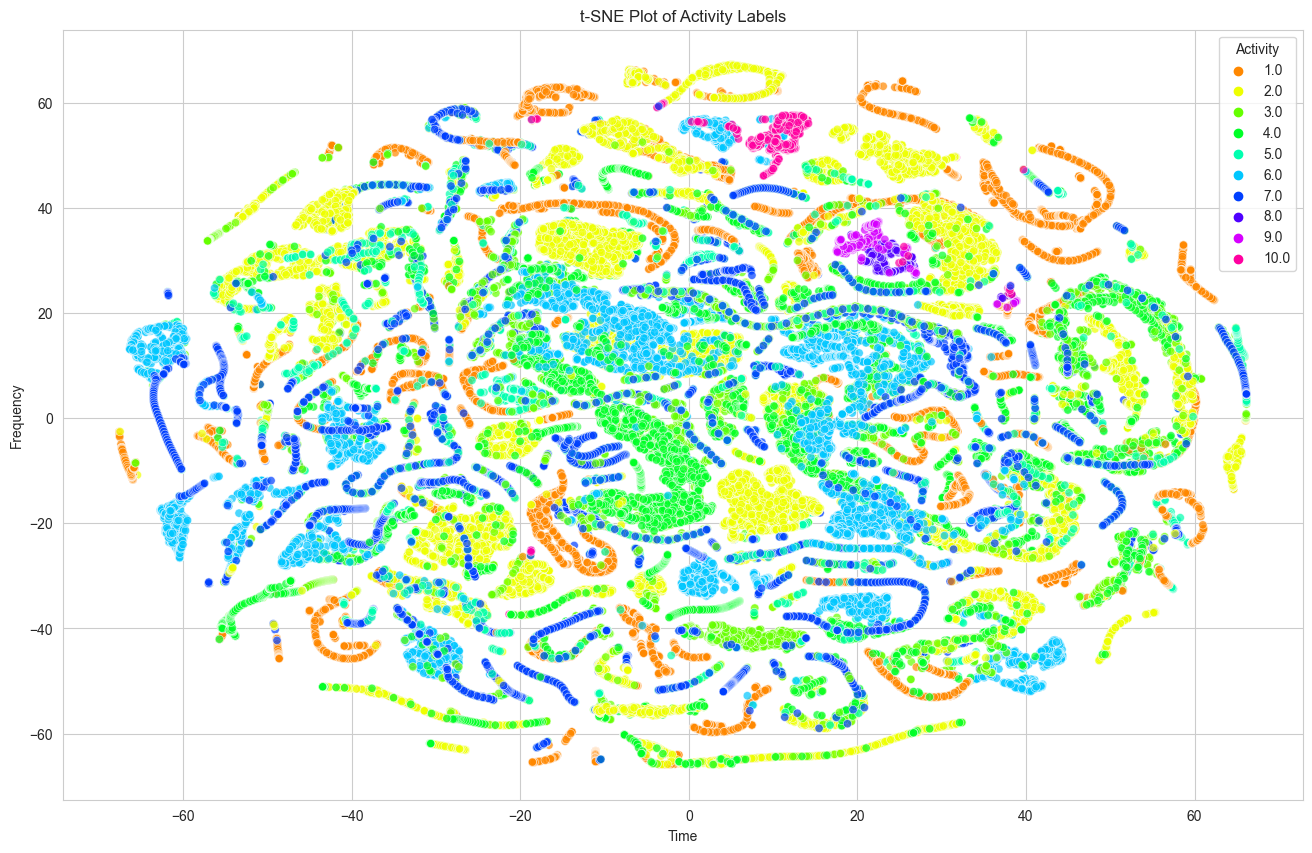

In [27]:
# TSNE
from sklearn.manifold import TSNE
import seaborn as sns

train_feature_matrix = train_feature_matrix.dropna()
features = train_feature_matrix.iloc[:, :-1]
labels = train_feature_matrix['Activity_Label']

tsne = TSNE().fit_transform(features)

plot_data = pd.DataFrame({
    'Time': tsne[:, 0],
    'Frequency': tsne[:, 1],
    'Activity': labels
})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="Time", y="Frequency",
    hue="Activity",
    palette=sns.color_palette("hsv", len(plot_data['Activity'].unique())),
    data=plot_data,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Plot of Activity Labels')
plt.show()

Based on my plot, I only discover some ability to differentiate between various activities, there is room for improvement. Activities that are stationary versus those that are moving may require more distinct features to be better separated. 

Possible reasons for this are:
* Data problem: The current set of features may not be optimal and some data features should not be selected.
* Sampling rate: Different sampling rate may have better classification
* Calss imbalance: For the previous data distribution, we know that the dataset is imbalanced with a disproportionate number of samples for certain activities. 

Based on the plot, it also can suggest that the training process may not yield a high degree of accuracy.

TO DO

###  KNN and Random Forest Classification. Compute the confusion matrix and then compute the precision, recall and F1 score for each activity separately. Compare the performance of these two classifiers and comment on it.

In [28]:
x_list_test_features = compute_features(x_list_test)
y_list_test_features = compute_features(y_list_test)
z_list_test_features = compute_features(z_list_test)
b_list_test_features = compute_features(b_list_test)

test_labels_df = pd.DataFrame(test_labels)
test_labels_df.columns = ['Activity_Label']

dfs_to_merge = [x_list_test_features, y_list_test_features, z_list_test_features, b_list_test_features, test_labels_df]
test_feature_matrix = pd.concat(dfs_to_merge, axis=1)

In [29]:
X_train = train_feature_matrix.iloc[:, :-1]
y_train = train_feature_matrix['Activity_Label']
X_test = test_feature_matrix.iloc[:, :-1]
y_test = test_feature_matrix['Activity_Label']

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

knn_clf = KNeighborsClassifier(n_neighbors=10)
rf_clf = RandomForestClassifier(random_state=42)

# Train
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
# Test
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

knn_confusion_matrix = confusion_matrix(y_test, knn_pred)
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
knn_report = classification_report(y_test, knn_pred, output_dict=True)
rf_report = classification_report(y_test, rf_pred, output_dict=True)

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

KNN Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      2246
         2.0       0.00      0.00      0.00      3896
         3.0       0.20      0.13      0.16      1218
         4.0       0.30      0.16      0.21       856
         5.0       0.32      0.16      0.21      1200
         6.0       0.00      0.00      0.00      1398
         7.0       0.08      0.55      0.14      1421

    accuracy                           0.10     12235
   macro avg       0.13      0.14      0.10     12235
weighted avg       0.08      0.10      0.07     12235

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.08      0.14      2246
         2.0       0.43      0.18      0.26      3896
         3.0       0.04      0.06      0.04      1218
         4.0       0.15      0.58      0.24       856
         5.0       0.47      0.65      0.55      1200
         6.0  

The classification reports for both the KNN and Random Forest classifiers indicate relatively low accuracy scores. This outcome aligns with the earlier assessment drawn from the t-SNE plot, which suggested a lack of clear separation among the different activities. In particular, the KNN classifier demonstrates very limited effectiveness, with a weighted average F1-score of only 0.07, and an overall accuracy of 10%. The Random Forest classifier fares somewhat better, with a weighted average F1-score of 0.30 and an accuracy of 31%.

TO DO

### Time Domain vs Frequency Domain

### Use just time domain and frequency domain features seperately and run the same classifier. Which domain ( frequency domain vs time domain ) is helping you the most in terms of building your activity recognition system ? Comment on it.

In [32]:
# TD vs FD

def compute_features_TD(windows):
    features_list = []
    
    for i, window in enumerate(windows):
        td_features = compute_time_domain_features(window)
        all_features = {**td_features}
        features_list.append(all_features)
    
    feature_matrix = pd.DataFrame(features_list)
    
    return feature_matrix


def compute_features_FD(windows):
    features_list = []
    
    for i, window in enumerate(windows):
        fd_features = compute_frequency_domain_features(window)
        all_features = {**fd_features}
        features_list.append(all_features)
    
    feature_matrix = pd.DataFrame(features_list)
    
    return feature_matrix

x_list_train_features_td = compute_features_TD(x_list_train)
y_list_train_features_td = compute_features_TD(y_list_train)
z_list_train_features_td = compute_features_TD(z_list_train)
b_list_train_features_td = compute_features_TD(b_list_train)
dfs_to_merge = [x_list_train_features_td,
                y_list_train_features_td,
                z_list_train_features_td, 
                b_list_train_features_td, train_labels_df]
train_feature_matrix_td = pd.concat(dfs_to_merge, axis=1)

x_list_train_features_fd = compute_features_FD(x_list_train)
y_list_train_features_fd = compute_features_FD(y_list_train)
z_list_train_features_fd = compute_features_FD(z_list_train)
b_list_train_features_fd = compute_features_FD(b_list_train)

dfs_to_merge = [x_list_train_features_fd, 
                y_list_train_features_fd, 
                z_list_train_features_fd, 
                b_list_train_features_fd, train_labels_df]
train_feature_matrix_fd = pd.concat(dfs_to_merge, axis=1)

In [33]:
x_list_test_features_td = compute_features_TD(x_list_test)
y_list_test_features_td = compute_features_TD(y_list_test)
z_list_test_features_td = compute_features_TD(z_list_test)
b_list_test_features_td = compute_features_TD(b_list_test)
dfs_to_merge = [x_list_test_features_td,
                y_list_test_features_td,
                z_list_test_features_td, 
                b_list_test_features_td, test_labels_df]
test_feature_matrix_td = pd.concat(dfs_to_merge, axis=1)

x_list_test_features_fd = compute_features_FD(x_list_test)
y_list_test_features_fd = compute_features_FD(y_list_test)
z_list_test_features_fd = compute_features_FD(z_list_test)
b_list_test_features_fd = compute_features_FD(b_list_test)

dfs_to_merge = [x_list_test_features_fd, 
                y_list_test_features_fd, 
                z_list_test_features_fd, 
                b_list_test_features_fd, test_labels_df]
test_feature_matrix_fd = pd.concat(dfs_to_merge, axis=1)

#### TD

In [34]:
train_feature_matrix_td = train_feature_matrix_td.dropna()
test_feature_matrix_td = test_feature_matrix_td.dropna()

X_train = train_feature_matrix_td.iloc[:, :-1]
y_train = train_feature_matrix_td['Activity_Label']
X_test = test_feature_matrix_td.iloc[:, :-1]
y_test = test_feature_matrix_td['Activity_Label']

In [35]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
rf_clf = RandomForestClassifier(random_state=42)

# Train
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
# Test
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

In [36]:
knn_confusion_matrix = confusion_matrix(y_test, knn_pred)
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
knn_report = classification_report(y_test, knn_pred, output_dict=True)
rf_report = classification_report(y_test, rf_pred, output_dict=True)

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

KNN Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      2246
         2.0       0.00      0.00      0.00      3896
         3.0       0.20      0.13      0.16      1218
         4.0       0.30      0.16      0.21       856
         5.0       0.32      0.16      0.21      1200
         6.0       0.00      0.00      0.00      1398
         7.0       0.08      0.55      0.14      1421

    accuracy                           0.10     12235
   macro avg       0.13      0.14      0.10     12235
weighted avg       0.08      0.10      0.07     12235

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.58      0.07      0.13      2246
         2.0       0.52      0.31      0.39      3896
         3.0       0.03      0.05      0.04      1218
         4.0       0.18      0.56      0.28       856
         5.0       0.46      0.67      0.54      1200
         6.0  

#### FD

In [37]:
train_feature_matrix_fd = train_feature_matrix_fd.dropna()
test_feature_matrix_fd = test_feature_matrix_fd.dropna()

X_train = train_feature_matrix_fd.iloc[:, :-1]
y_train = train_feature_matrix_fd['Activity_Label']
X_test = test_feature_matrix_fd.iloc[:, :-1]
y_test = test_feature_matrix_fd['Activity_Label']

In [38]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
rf_clf = RandomForestClassifier(random_state=42)

# Train
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
# Test
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

In [39]:
knn_confusion_matrix = confusion_matrix(y_test, knn_pred)
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
knn_report = classification_report(y_test, knn_pred, output_dict=True)
rf_report = classification_report(y_test, rf_pred, output_dict=True)

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

KNN Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      2246
         2.0       0.00      0.00      0.00      3896
         3.0       0.20      0.13      0.16      1218
         4.0       0.30      0.16      0.21       856
         5.0       0.32      0.15      0.21      1200
         6.0       0.00      0.00      0.00      1398
         7.0       0.08      0.56      0.14      1421

    accuracy                           0.10     12235
   macro avg       0.13      0.14      0.10     12235
weighted avg       0.08      0.10      0.07     12235

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.55      0.10      0.17      2246
         2.0       0.14      0.01      0.03      3896
         3.0       0.02      0.03      0.02      1218
         4.0       0.13      0.78      0.23       856
         5.0       0.27      0.32      0.29      1200
         6.0  

The Random Forest classifier achieves better accuracy and overall higher precision, recall, and F1 scores across most activities, particularly with TD features, where the accuracy peaks at 35%. This suggests a stronger discriminative capability of TD features in distinguishing various activities. In contrast, the classifiers' performances drop when trained on FD features, with Random Forest's accuracy descending to 22%. 

Therefore, we can make a conclusion that the time domain is helping me the most in classifications. 

TO DO

### Cross validation- you will implement Leave One Subject Out Cross Validation .  For this task, you are free to select any classifier you like.


In [40]:
# Subject ID is same to activity label in this case

In [41]:
# Cross Validation - All features
import copy
X_train = train_feature_matrix.iloc[:, :-1]
y_train = train_feature_matrix['Activity_Label']
X_test = test_feature_matrix.iloc[:, :-1]
y_test = test_feature_matrix['Activity_Label']

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

cv = LeaveOneOut()
y_true, y_pred = [], []

print("Cross Validation")
for train_ix, test_ix in cv.split(X):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    y_true.append(y_test.iloc[0]) 
    y_pred.append(yhat[0])

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc:.3f}')

In [ ]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
subject_ids = y.copy()

print("Cross Validation")
cv = LeaveOneOut()
model = RandomForestClassifier(random_state=32)

scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

BONUS POINTS

### Try building a basic CNN model and use either the raw time series data or the extracted feature set as input and try to classify the different activities


In [ ]:
df_raw

In [ ]:
X = df_raw.iloc[:, :-3]
y =  df_raw.iloc[:, -3]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


X_np = X.copy()
y_np = tf.keras.utils.to_categorical(y) 

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(y_train_np.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_np, y_train_np, epochs=10, validation_data=(X_test_np, y_test_np))

In [ ]:
loss, accuracy = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Accuracy: {accuracy:.4f}")